In [1]:
#@title Load utility functions for data loading and preprocessing
from typing import Optional, Tuple, Type, Union
import torch
from torchvision import datasets, transforms
import numpy as np
from PIL import Image
from torchvision.transforms import ToTensor

In [2]:
def get_mnist(dataset) -> Tuple[torch.Tensor]:
    # !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
    # !tar -zxvf MNIST.tar.gz
    imstack_data_r = torch.zeros_like(dataset.data, dtype=torch.float32)
    labels = []
    for i, (im, lbl) in enumerate(dataset):
        imstack_data_r[i] = ToTensor()(im)
        labels.append(lbl)
    imstack_data_r /= imstack_data_r.max()
    return imstack_data_r, torch.tensor(labels)

In [ ]:
def get_rotated_mnist(dataset, rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    # !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
    # !tar -zxvf MNIST.tar.gz
    imstack_data_r = torch.zeros_like(dataset.data, dtype=torch.float32)
    labels, angles = [], []
    for i, (im, lbl) in enumerate(dataset):
        theta = torch.randint(*rotation_range, (1,)).float()
        im = im.rotate(theta.item(), resample=Image.BICUBIC)
        imstack_data_r[i] = ToTensor()(im)
        labels.append(lbl)
        angles.append(torch.deg2rad(theta))
    imstack_data_r /= imstack_data_r.max()
    return imstack_data_r, torch.tensor(labels), torch.tensor(angles)


In [ ]:
def get_half_labels_rotated_mnist2(dataset, rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    # !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
    # !tar -zxvf MNIST.tar.gz
    data, labels, angles = [], [], []
    count = torch.zeros(10)
    for i, (im, lbl) in enumerate(dataset):
        if lbl<5:
            if count[lbl]<1000:
                theta = torch.randint(*rotation_range, (1,)).float()
                im = im.rotate(theta.item(), resample=Image.BICUBIC)
                data.append(ToTensor()(im))
                labels.append(lbl)
                angles.append(torch.deg2rad(theta))
                count[lbl] = count[lbl]+1
        else:
            if count[lbl]<1000:
                data.append(ToTensor()(im))
                labels.append(lbl)
                angles.append(0)
                count[lbl] = count[lbl]+1
    return torch.cat(data), torch.tensor(labels), torch.tensor(angles)

In [ ]:
def init_dataloader(*args: torch.Tensor, **kwargs: int
                    ) -> Type[torch.utils.data.DataLoader]:

    batch_size = kwargs.get("batch_size", 100)
    tensor_set = torch.utils.data.dataset.TensorDataset(*args)
    data_loader = torch.utils.data.DataLoader(
        dataset=tensor_set, batch_size=batch_size, shuffle=True)
    return data_loader

In [8]:
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim import Adam
import dataclasses
from tqdm import tqdm
import torch.utils.data as data_utils

NUM_EPOCHS = 100
LR = 6e-4
device = torch.device("cuda")

class MLP(nn.Module):
    def __init__(self, in_channels= 300, out_channels=5, num_hidden=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_channels,num_hidden)
        self.fc2 = nn.Linear(num_hidden,num_hidden)
        self.fc3 = nn.Linear(num_hidden,out_channels)

    def forward(self, x):
        # x=torch.flatten(x, start_dim=1) # Flatten layer
        x=F.relu(self.fc1(x)) 
        x=F.relu(self.fc2(x)) 
        x=F.softmax(self.fc3(x))
        return x
    
def train_nn(model, template0, template1, template2, train_dataset, test_dataset, batch_size=32, num_epochs=NUM_EPOCHS, lr=LR, criterion=nn.CrossEntropyLoss()):
    
    TrainResult = {'train_losses': [], 'val_accs': []}
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(num_epochs):
        total_train = 0
        model.train()
        for datapoint in tqdm(train_loader):
            X, y = datapoint[0].to(device), datapoint[1].to(device)
            batch_len = X.shape[0]
            X = X.view(-1, batch_len)    
            emb0 = torch.mm(template0.to(device), X)
            emb0 = [torch.histc(emb0[i], bins=100, min=0, max=784) for i in range(batch_len)]
            emb0 = torch.stack(emb0)
            emb1 = torch.mm(template1.to(device), X)
            emb1 = [torch.histc(emb1[i], bins=100, min=0, max=784) for i in range(batch_len)]
            emb1 = torch.stack(emb1)
            emb2 = torch.mm(template2.to(device), X)
            emb2 = [torch.histc(emb2[i], bins=100, min=0, max=784) for i in range(batch_len)]
            emb2 = torch.stack(emb2)
            emb = torch.cat((emb0, emb1, emb2), dim=1)
            optimizer.zero_grad()
            output = model(emb)
            loss = criterion(output, y)
            total_train += loss.item()
            loss.backward()
            optimizer.step()
        
        total_train = total_train/len(train_loader)
        TrainResult['train_losses'].append(total_train)
                               
        model.eval()
        total_val = 0
        with torch.no_grad():
            for bidx, datapoint in enumerate(test_loader):
                X, y = datapoint[0].to(device), datapoint[1].to(device)
                batch_len = X.shape[0]
                X = X.view(-1, batch_len)    
                emb0 = torch.mm(template0.to(device), X)
                emb0 = [torch.histc(emb0[i], bins=100, min=0, max=784) for i in range(batch_len)]
                emb0 = torch.stack(emb0)
                emb1 = torch.mm(template1.to(device), X)
                emb1 = [torch.histc(emb1[i], bins=100, min=0, max=784) for i in range(batch_len)]
                emb1 = torch.stack(emb1)
                emb2 = torch.mm(template2.to(device), X)
                emb2 = [torch.histc(emb2[i], bins=100, min=0, max=784) for i in range(batch_len)]
                emb2 = torch.stack(emb2)
                emb = torch.cat((emb0, emb1, emb2), dim=1)
                optimizer.zero_grad()
                output = model(emb)
                total_val += torch.sum(torch.argmax(output, dim=-1)==y).item()/output.size(dim=0)
        TrainResult['val_accs'].append(total_val/len(test_loader))
        print("Epoch {}: Train Loss={} Validation Accuracy={}%".format(epoch, TrainResult['train_losses'][-1], TrainResult['val_accs'][-1]*100))
    return TrainResult

In [9]:
# results = train_nn(model, temp0, temp1, mnist_trainset, mnist_testset, num_epochs = 40)

In [ ]:
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)
# train_data, train_labels, train_angles = get_half_labels_rotated_mnist2(mnist_trainset, rotation_range=[-60, 61])
# test_data, test_labels, test_angles = get_rotated_mnist(mnist_testset, rotation_range=[-60, 61])

train_data, train_labels = get_mnist(mnist_trainset)
test_data, test_labels = get_mnist(mnist_testset)

train_loader = init_dataloader(train_data, batch_size=200)
test_loader = init_dataloader(test_data, batch_size=200)


In [9]:
train_data_unseen_labels = train_data[train_labels>=5]
train_labels_unseen_labels = train_labels[train_labels>=5]
test_data_unseen_labels = test_data[test_labels>=5]
test_labels_unseen_labels = test_labels[test_labels>=5]
mnist_trainset = [[train_data_unseen_labels[i], train_labels_unseen_labels[i]-5] for i in range(len(train_data_unseen_labels))]
mnist_testset = [[test_data_unseen_labels[i], test_labels_unseen_labels[i]-5] for i in range(len(test_data_unseen_labels))]

In [10]:
temp0 = torch.flatten(train_data[train_labels==0], start_dim=1)
temp1 = torch.flatten(train_data[train_labels==1], start_dim=1)
temp2 = torch.flatten(train_data[train_labels==2], start_dim=1)

In [11]:
temp0.shape

torch.Size([5923, 784])

In [12]:
import numpy as np # linear algebra
import json
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog

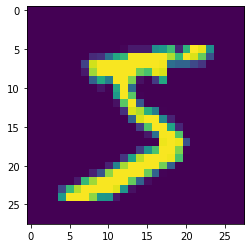

In [13]:
plt.imshow(train_data[0])

In [14]:
def calc_hog_features(X, image_shape=(28, 28), pixels_per_cell=(8, 8)):
    fd_list = []
    for row in X:
        img = row.reshape(image_shape)
        fd = hog(img, orientations=8, pixels_per_cell=pixels_per_cell, cells_per_block=(1, 1))
        fd_list.append(fd)
    
    return np.array(fd_list)

In [48]:
X_train = calc_hog_features(train_data, pixels_per_cell=(8, 8))

In [49]:
X_train.shape

(60000, 72)

In [51]:
from sklearn.decomposition import PCA
import scipy.stats as stats

pca = PCA()
pca.fit(X_train)
X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

X_train = stats.zscore(X_train)
# X_test = stats.zscore(X_test)

In [52]:
X_train.shape

(60000, 72)

In [53]:
X_train[:5].shape

(5, 72)

In [58]:
np.matmul(X_train[:5], X_train.T).shape

(5, 60000)

In [35]:
torch.bincount(test_labels)

tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])

In [18]:
model = MLP()
model.to(device)

MLP(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)

In [1]:
results = train_nn(model, temp0, temp1, temp2, mnist_trainset, mnist_testset, num_epochs = 100)

In [ ]:
for datapoint in tqdm(train_loader):
            X, y = datapoint[0].to(device), datapoint[1].to(device)
            batch_len = X.shape[0]
            X = X.view(-1, batch_len)    
            emb0 = torch.mm(template0.to(device), X)
            emb0 = [torch.histc(emb0[i], bins=100, min=0, max=784) for i in range(batch_len)]
            emb0 = torch.stack(emb0)
            emb1 = torch.mm(template1.to(device), X)
            emb1 = [torch.histc(emb1[i], bins=100, min=0, max=784) for i in range(batch_len)]
            emb1 = torch.stack(emb1)
            emb2 = torch.mm(template2.to(device), X)
            emb2 = [torch.histc(emb2[i], bins=100, min=0, max=784) for i in range(batch_len)]
            emb2 = torch.stack(emb2)
            emb = torch.cat((emb0, emb1, emb2), dim=1)
            optimizer.zero_grad()

In [12]:
im = train_data[0]

In [14]:
im.shape

torch.Size([28, 28])